# Build the data set

Um unser Projektziel umzusetzen, stellen wir uns einen Datensatz zusammen, der folgende Daten enthält:

- tägliche Anzahl gemessener Fahrradfahrer von Zähler in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.')
- mittlere tägliche Temperatur
- boolean, ob Tag Wochentag oder Werktag ist

Dazu importieren wir im Folgenden stündliche Zählerstände verschiedener Fahrradfahrerzählstationen aus dem Jahr 2021. Aus diesen Daten berechnen wir tägliche Zählersummen.

Wir extrahieren die Daten von genau einem Zähler (Freiburg, channel name: 'FR1 Dreisam / Hindenburgstr.') und betrachten in der Analyse nur die täglichen Zählersummen dieses Zählers.

Für den Standort dieses Zählers importieren wir Temperaturdaten.

Außerdem berechnen wir für jedes Datum vom 2021-01-01 bis 2021-12-31, ob es sich dabei um einen Werktag oder Wochenende handelt.

All diese Daten fügen wir dann in einem gemeinsamen Datensatz zusammen. Dieser ist weiter unten als 'combined_daily_dat' zu finden.

With hourly bike rider counts from https://www.mobidata-bw.de/dataset/eco-counter-fahrradzahler and temperature data from https://dev.meteostat.net/python/, we construct a dataset of the following form:

| daily mean temperature | is business day | daily bike rider count |
| --- | --- | --- |
|... | ... | ... |

_daily mean temperature_ is measured in °C.  
_is business day_ is either $0$ (Saturday or Sunday) or $1$ (Monday, Tuesday, Wednesday, Thursday or Friday)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from meteostat import Point, Daily

## Import bike rider counts data

In [2]:
# paths to data (one file per month)
dat_paths = ['./../data/raw/bike_rider_counts/eco_counter_fahrradzaehler_20210' + str(i) + '.csv' for i in range(1,10)]
dat_paths = dat_paths + ['./../data/raw/bike_rider_counts/eco_counter_fahrradzaehler_2021' + str(i) + '.csv' for i in range(10,13)]

# read in the data
dats = [pd.read_csv(path) for path in dat_paths]

# concatenate monthly data to get data of whole year in one dataframe
dat = pd.concat(dats)

In [3]:
# check whether import of data worked
dat.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2021-01-01T01:00:00+0000,2021-01-01T01:00:00+0100,2,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
1,2021-01-01T02:00:00+0000,2021-01-01T02:00:00+0100,0,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
2,2021-01-01T03:00:00+0000,2021-01-01T03:00:00+0100,1,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
3,2021-01-01T04:00:00+0000,2021-01-01T04:00:00+0100,1,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
4,2021-01-01T05:00:00+0000,2021-01-01T05:00:00+0100,2,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496


Eine Zeile entspricht einer Messung. Gemessen wird stündlich. Nicht für jede Messstelle sind das ganze Jahr über Daten gelistet.

Bisher versteht ich den Datensatz folgendermaßen:  
Innerhalb eines 'standort' (siehe Spaltenname oben) gibt es verschiedene 'counter_site', an denen es wiederum verschiedene 'channel_name' geben kann.

Beispiel:  
Am Standort 'Stadt Freiburg' gibt es 3 'counter_sites' ('FR1 Dreisam / Otto-Wels-Str.', 'FR2 Güterbahn / Ferd.-Weiß-Str.', und 'FR3 Eschholzstr. / Egonstr.'), an denen es dann wiederum jeweils 'channel_name' gibt.

### Compute daily counts

Measurements (bike rider counts) above are given hourly. Now, we sum them to get daily counts.

We want to sum the counts of one day at one counter.  
Before we can simply compute daily sums, we have to adjust the dates to "correct" for counts collected at midnight:  
Counts collected at midnight reflect bikers that passed the counting station in the hour before midnight. Therefore, they have to be taken into account in the sum for the "day before".

In [4]:
# add date information to dataframe

# make 'timestamp' date
dat['timestamp'] = pd.to_datetime(dat['timestamp'])

# add simpler date format to each measurement to make grouping by day easier
# For each measurement (row), we want to know on which day the data was 
# collected. In order to adjust for counts collected at midnight, we shift the 
# daytime by 1 hour before converting it to date.
# (Thereby, we can simply compute daily sums in the cell below;
#  adding "midnight counts" to the day before by shifting the daytime by 1 hour.)
dat['date'] = (dat['timestamp'] - pd.Timedelta(1, 'h')).dt.date

# determine for each date whether it is a business day
dat['is_busday'] = (dat['timestamp'] - pd.Timedelta(1, 'h')).dt.dayofweek < 5 # for Monday-Friday: dayofweek < 5

In [5]:
# sum counts of one day at one counting station
counters_by_daytype_daily = dat.groupby(by=['standort', 'counter_site', 'channel_name', 'longitude', 'latitude', 'date', 'is_busday'], as_index=False)['zählstand'].sum()

In [6]:
counters_by_daytype_daily

,standort,counter_site,channel_name,longitude,latitude,date,is_busday,zählstand
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,True,1668
...,...,...,...,...,...,...,...,...
27596,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,9.957680,48.40080,2021-04-26,True,653
27597,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,9.957680,48.40080,2021-04-27,True,708
27598,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,9.957680,48.40080,2021-04-28,True,630
27599,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,9.957680,48.40080,2021-04-29,True,382


In [7]:
# TODO get overview over data
cities = list(set(dat['standort']))
print('The dataset contains bike rider counts for the following cities:', cities)

The dataset contains bike rider counts for the following cities: ['Stadt Konstanz', 'Stadt Ulm', 'Stadt Offenburg', 'Stadt Freiburg', 'Stadt Heidelberg', 'Stadt Ludwisburg']




city:  Stadt Konstanz
citydat.shape:  (2416, 8)
	 countersite:  Fahrradbruecke
	 countersitedat.shape:  (1460, 8)
	 	 channel name:  Channel 2 OUT
	 	 channeldat.shape:  (365, 8)
	 	 channel name:  Channel 3 IN
	 	 channeldat.shape:  (365, 8)
	 	 channel name:  Channel 4 OUT
	 	 channeldat.shape:  (365, 8)
	 	 channel name:  Channel 1 IN
	 	 channeldat.shape:  (365, 8)
	 countersite:  S-Bahn Haltestelle Fürstenberg
	 countersitedat.shape:  (478, 8)
	 	 channel name:  S-Bahn Haltestelle Fürstenberg Cyclist IN
	 	 channeldat.shape:  (226, 8)
	 	 channel name:  S-Bahn Haltestelle Fürstenberg
	 	 channeldat.shape:  (26, 8)
	 	 channel name:  S-Bahn Haltestelle Fürstenberg Cyclist OUT
	 	 channeldat.shape:  (226, 8)
	 countersite:  S-Bahn-Haltestelle Petershausen-Süd
	 countersitedat.shape:  (478, 8)
	 	 channel name:  S-Bahn-Haltestelle Petershausen-Süd Fahrräder
	 	 channeldat.shape:  (26, 8)
	 	 channel name:  S-Bahn-Haltestelle Petershausen-Süd Cyclist IN
	 	 channeldat.shape:  (226, 

	 countersite:  Friedrich-Ebert-Straße
	 countersitedat.shape:  (1336, 8)
	 	 channel name:  Radweg C & D OUT
	 	 channeldat.shape:  (334, 8)
	 	 channel name:  Straße A & B IN
	 	 channeldat.shape:  (334, 8)
	 	 channel name:  Straße A & B OUT
	 	 channeldat.shape:  (334, 8)
	 	 channel name:  Radweg C & D IN
	 	 channeldat.shape:  (334, 8)
	 countersite:  Zugwiesen
	 countersitedat.shape:  (674, 8)
	 	 channel name:  Zugwiesen Stadteinwärts
	 	 channeldat.shape:  (337, 8)
	 	 channel name:  Zugwiesen Stadtauswärts
	 	 channeldat.shape:  (337, 8)
	 countersite:  Solitudeallee
	 countersitedat.shape:  (704, 8)
	 	 channel name:  Solitudeallee Stadtauswärts
	 	 channeldat.shape:  (352, 8)
	 	 channel name:  Solitudeallee Stadteinwärts
	 	 channeldat.shape:  (352, 8)
	 countersite:  Kesseläcker (Verl. Nussackerweg)
	 countersitedat.shape:  (702, 8)
	 	 channel name:  Kesseläcker (Verl. Nussackerweg) Stadteinwärts
	 	 channeldat.shape:  (351, 8)
	 	 channel name:  Kesseläcker (Verl. Nussa

<Figure size 640x480 with 0 Axes>

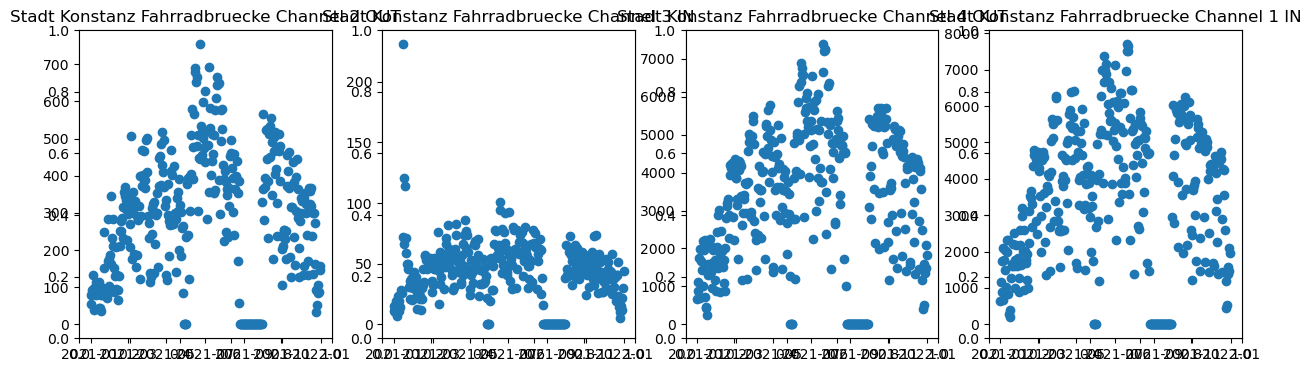

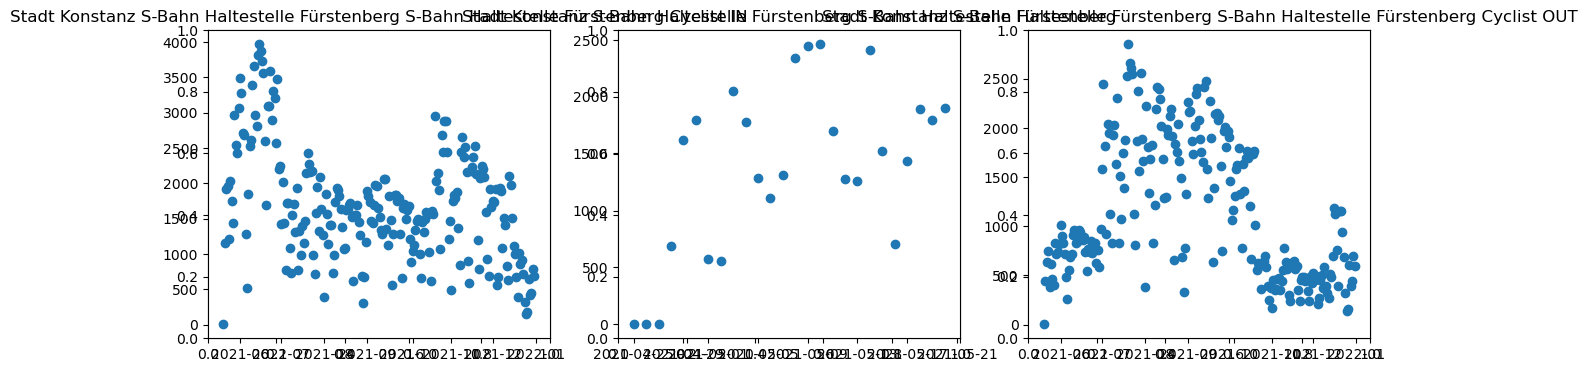

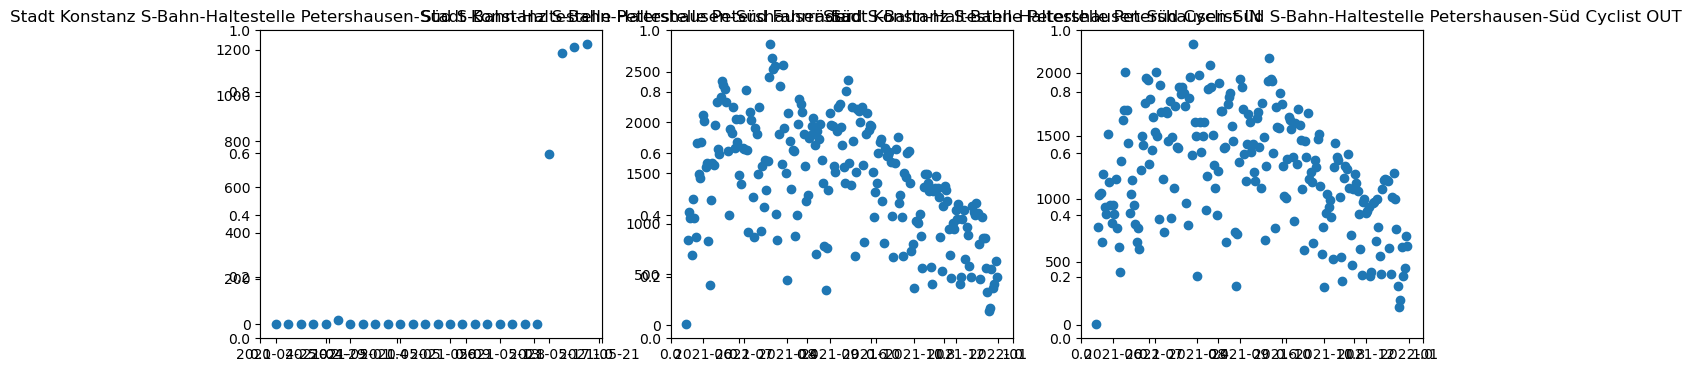

<Figure size 640x480 with 0 Axes>

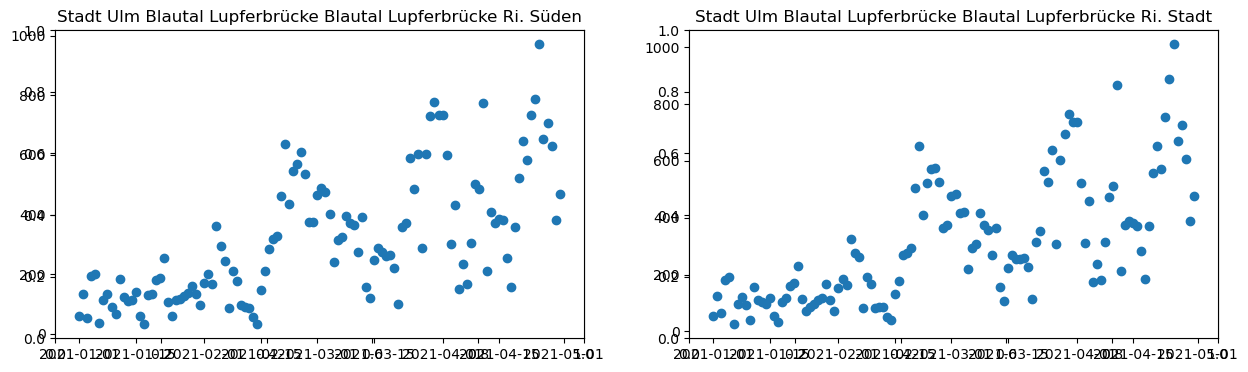

<Figure size 640x480 with 0 Axes>

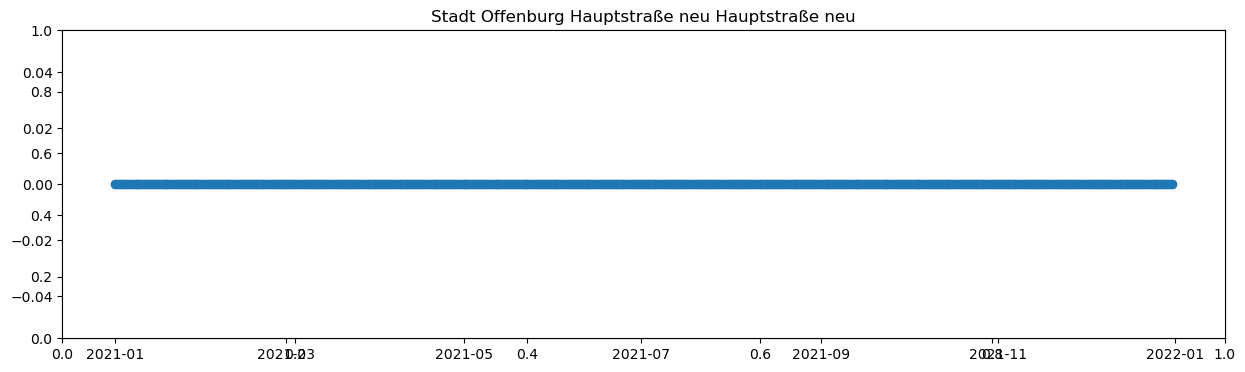

<Figure size 640x480 with 0 Axes>

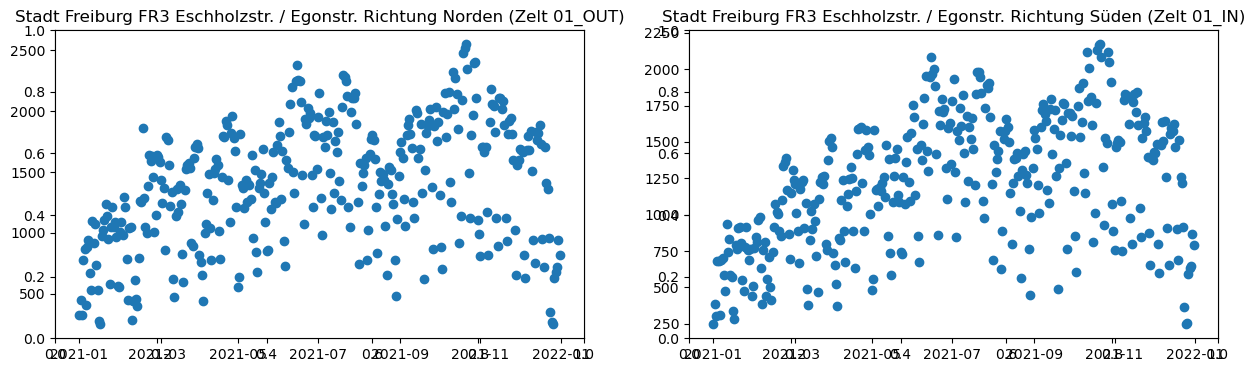

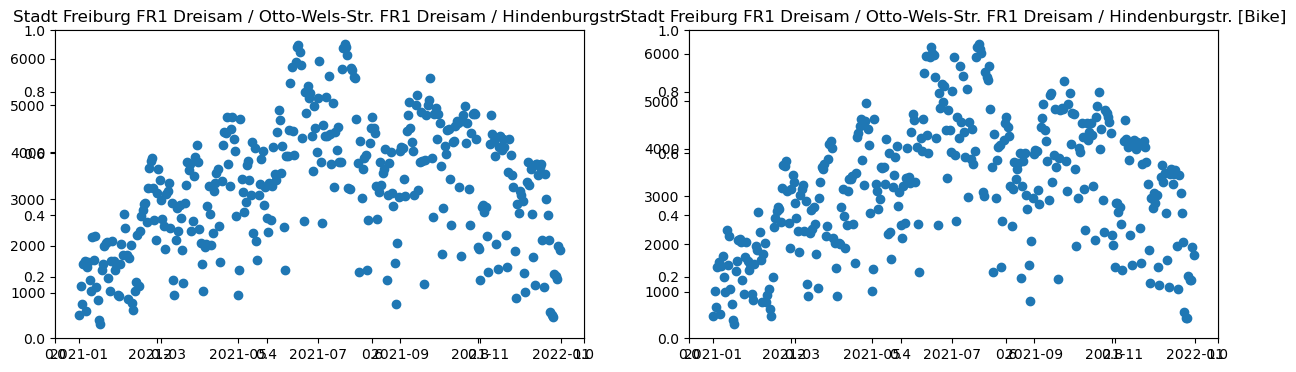

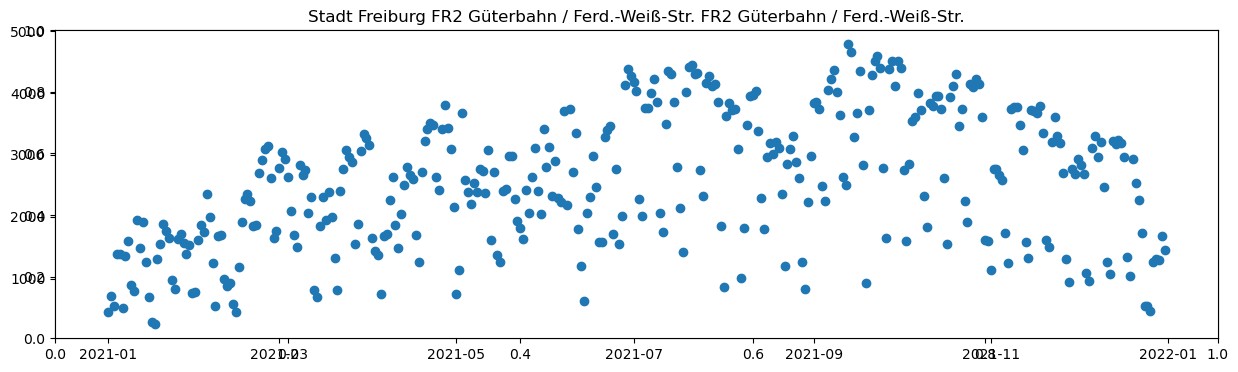

<Figure size 640x480 with 0 Axes>

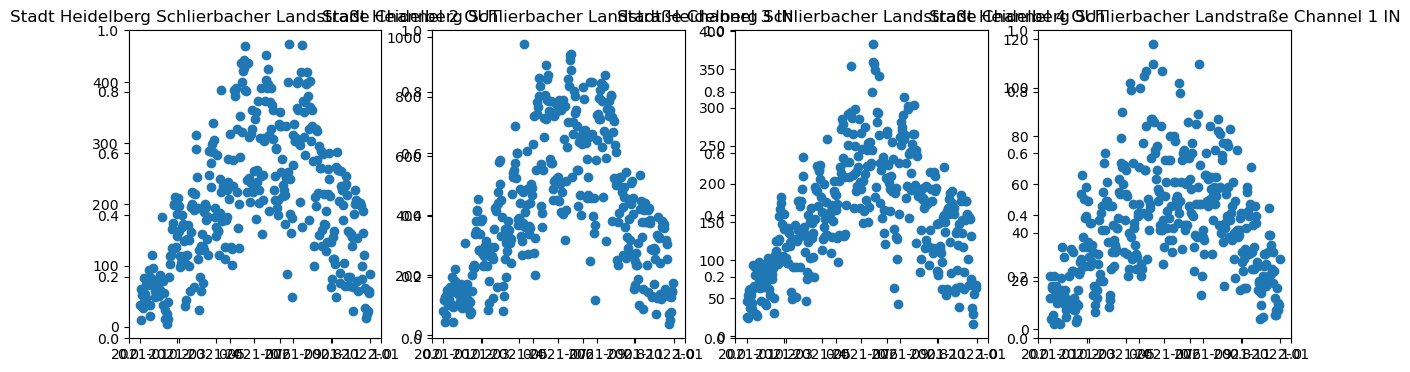

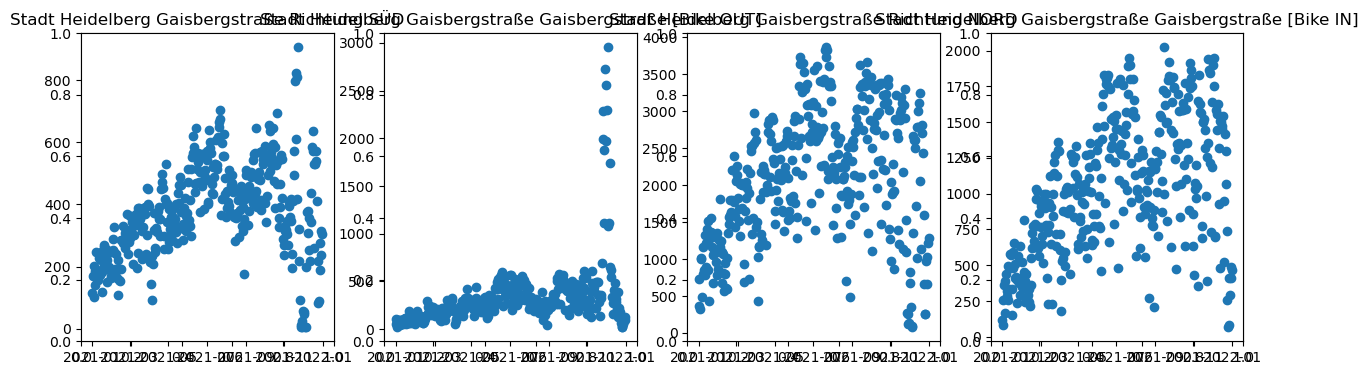

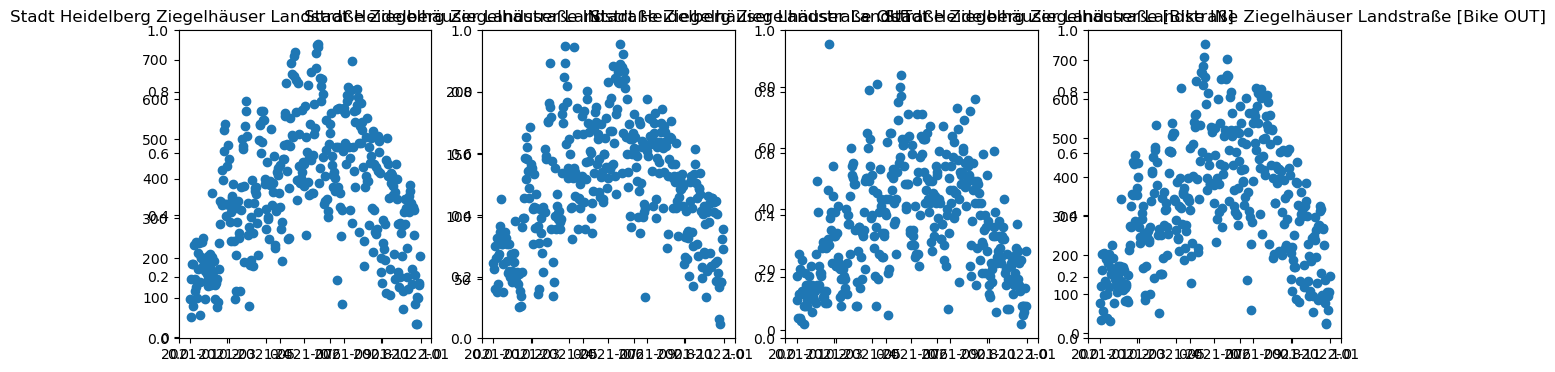

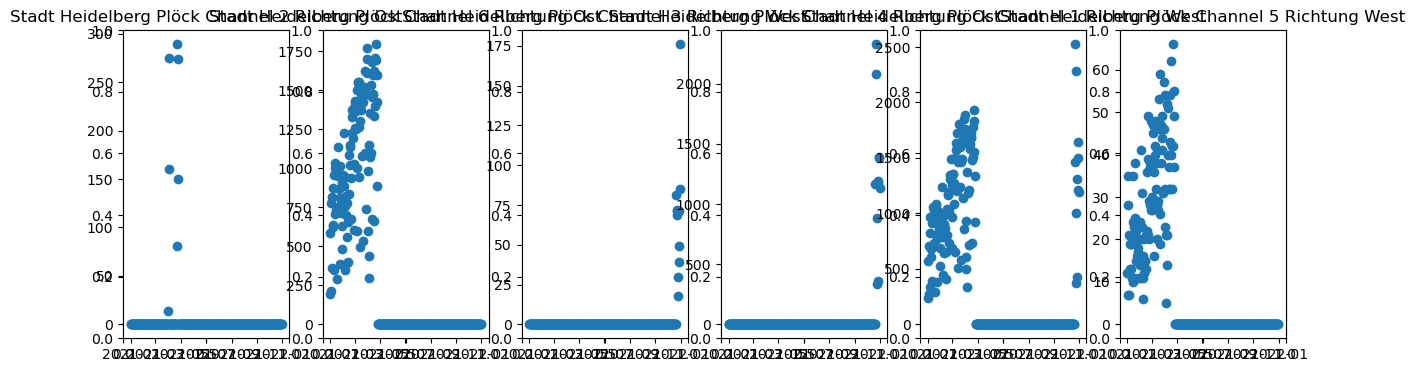

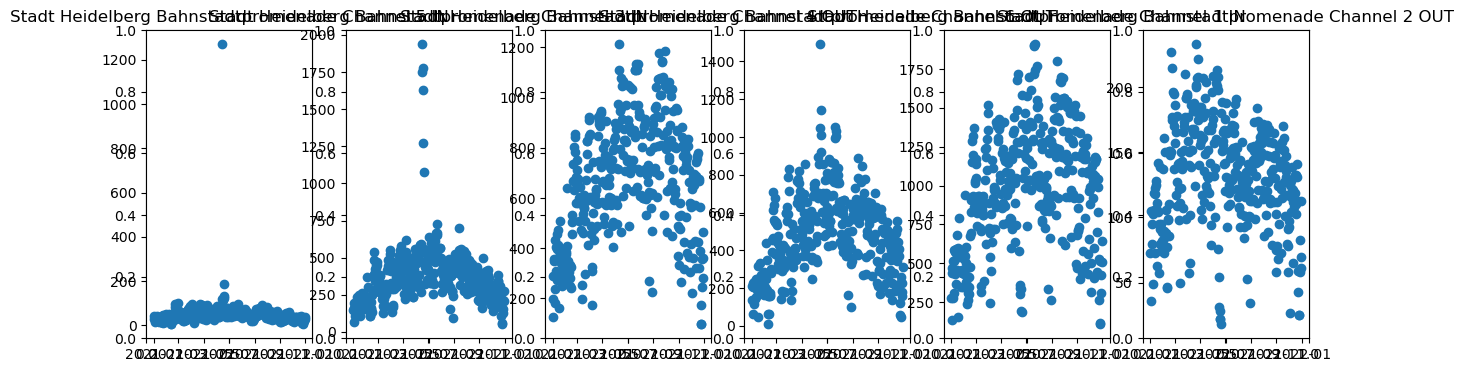

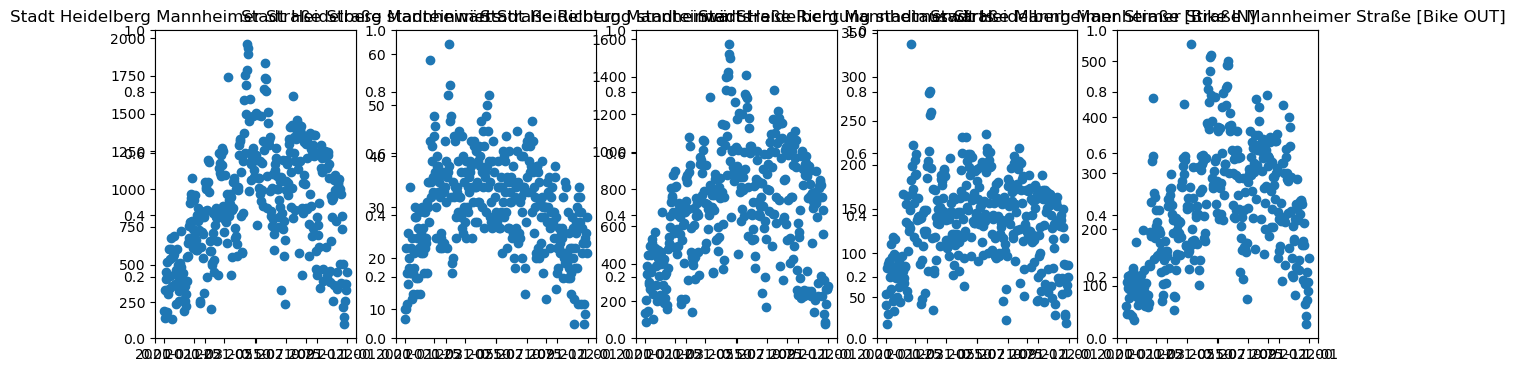

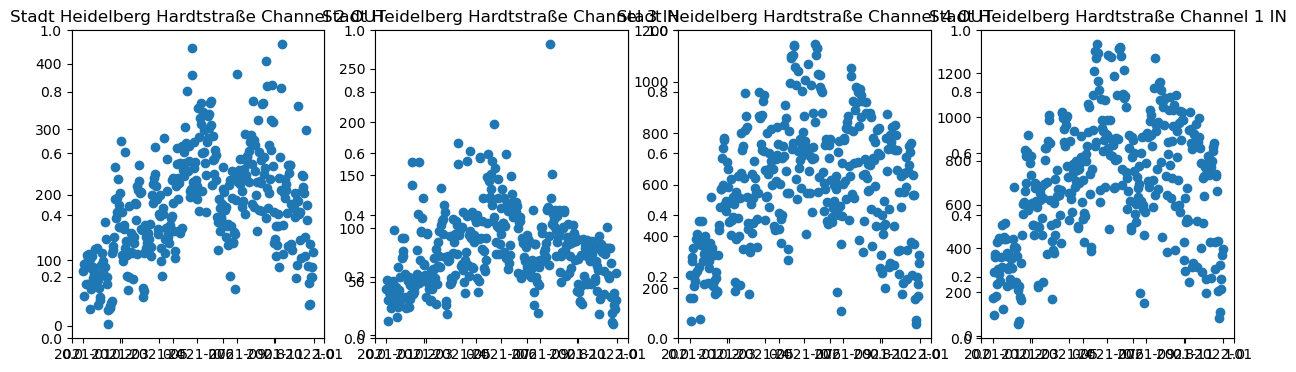

<Figure size 640x480 with 0 Axes>

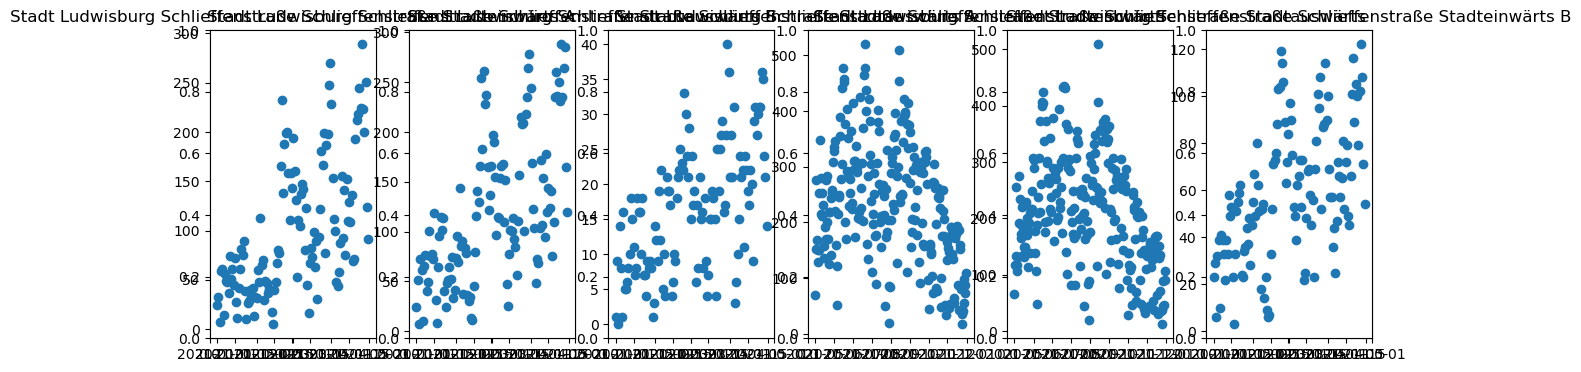

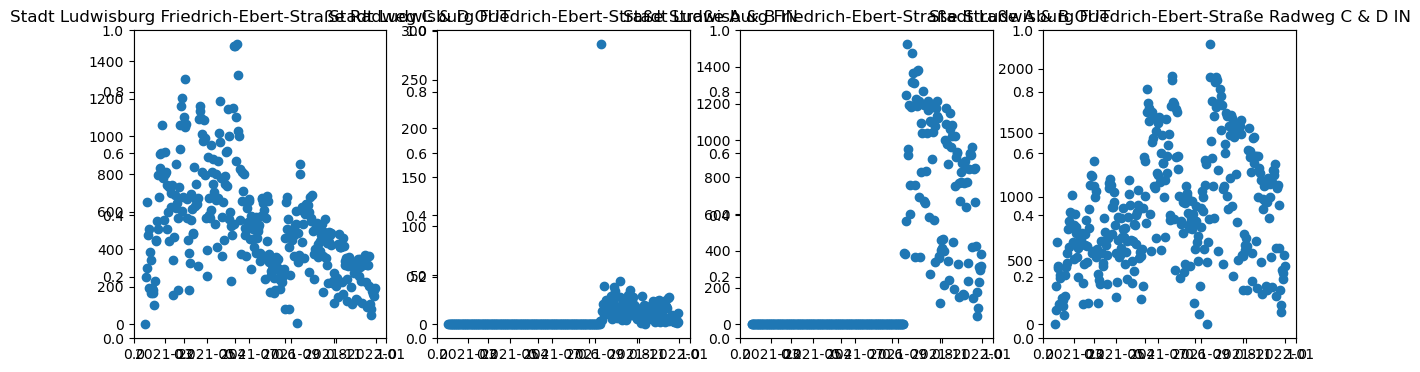

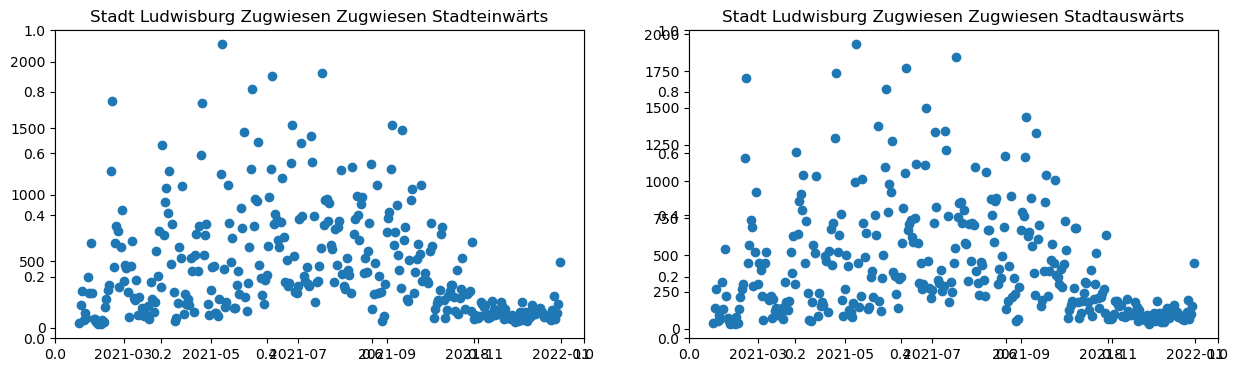

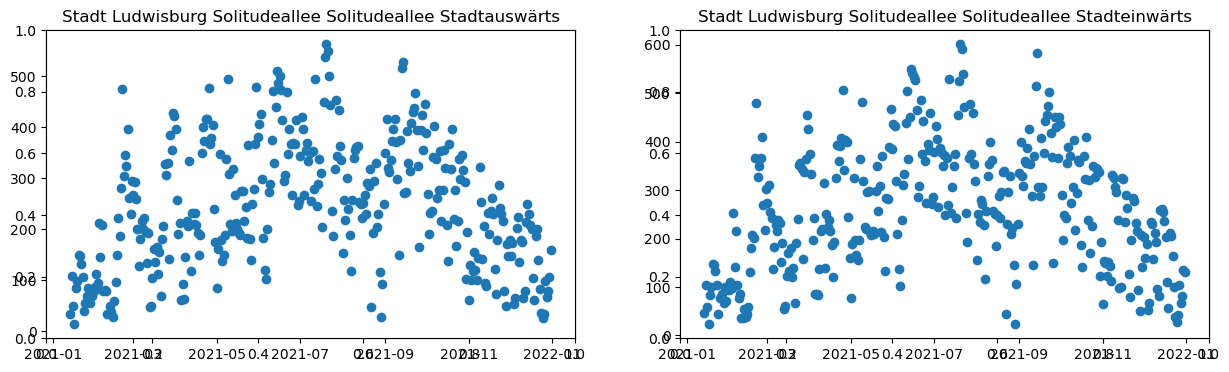

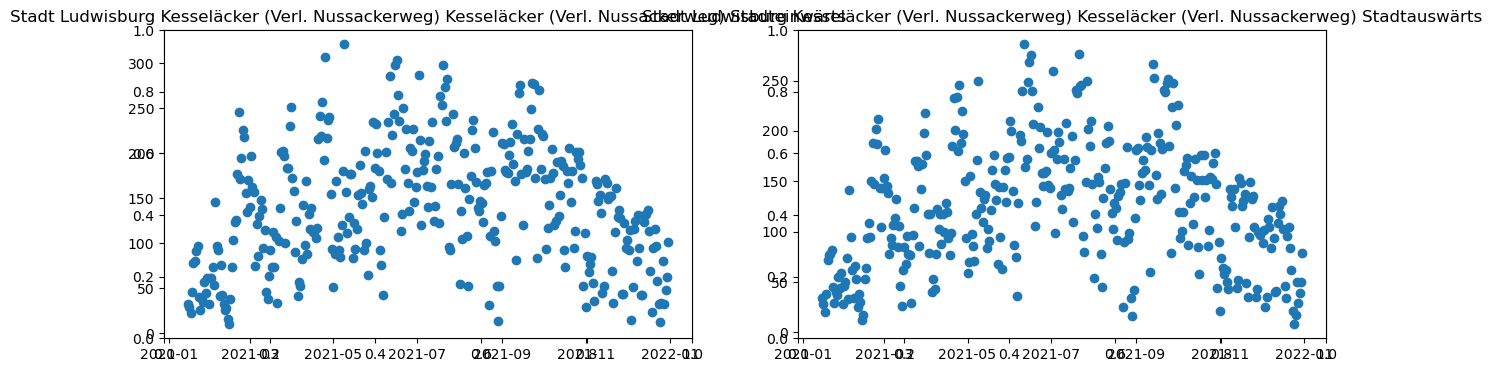

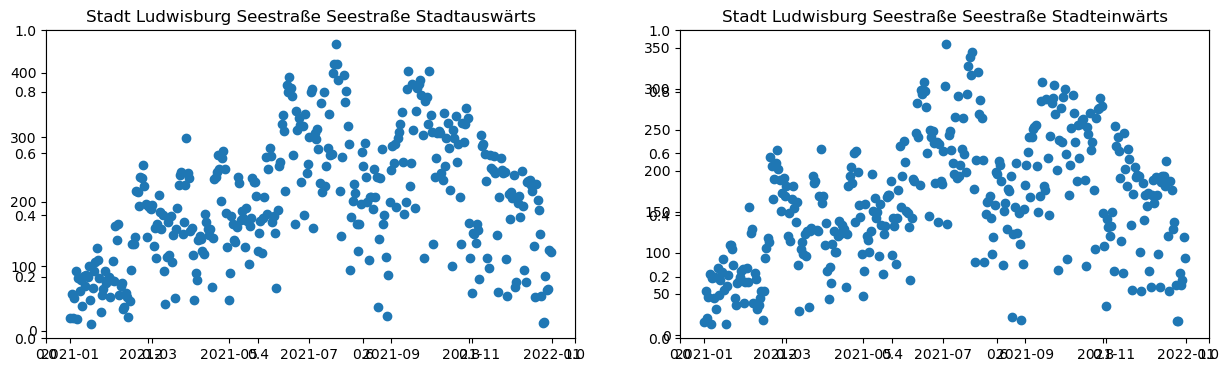

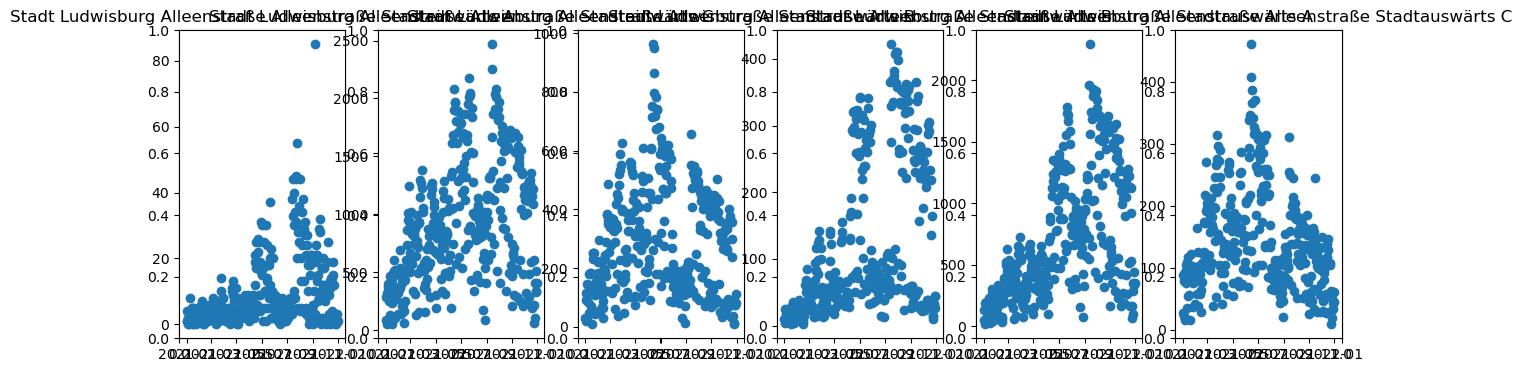

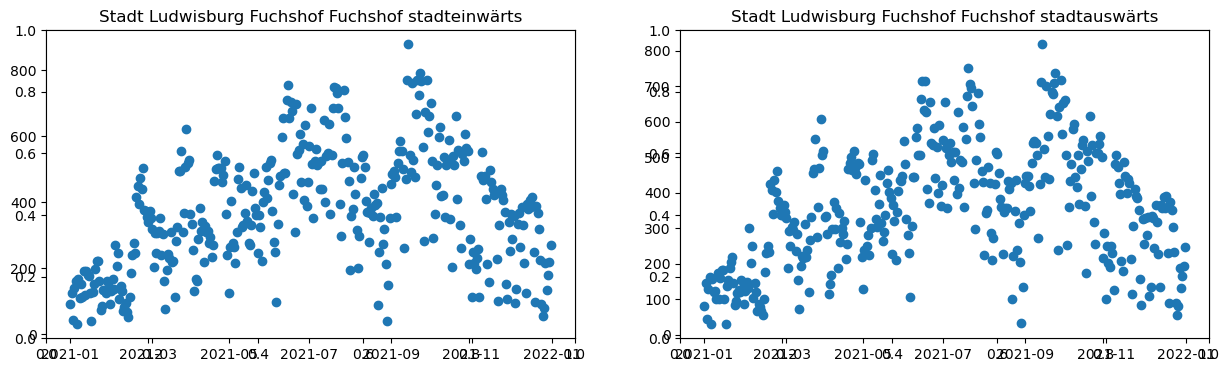

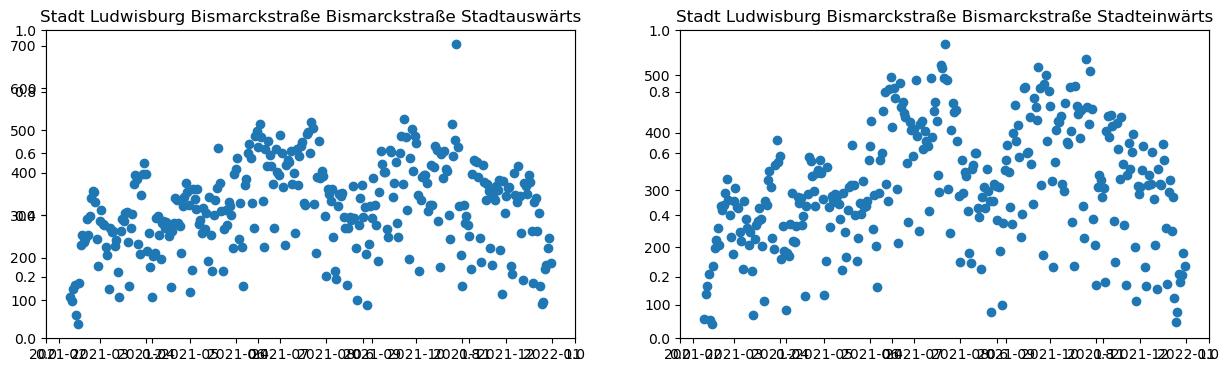

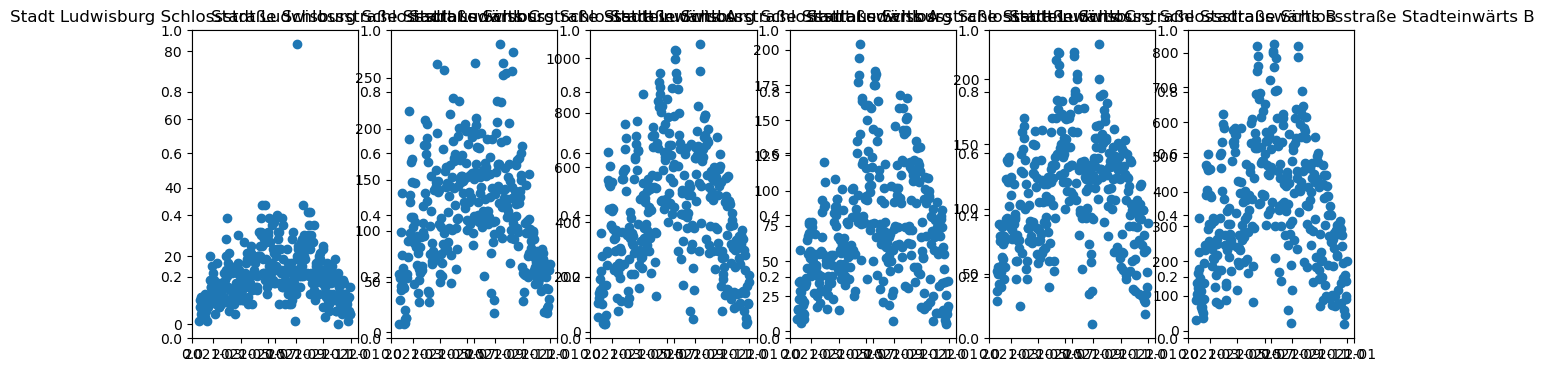

In [8]:
# TODO inspect whole dataset:
#   - which counter sites with channels exist in the different cities
#   - are there zero counts for some counter sites?
# TODO this cell is only for data inspection, plotting is not pretty...

for cityname in cities:
    plt.figure()
    
    print('\n')
    print('city: ', cityname)
    
    # extract data for city
    citydat = counters_by_daytype_daily.loc[counters_by_daytype_daily['standort']==cityname]
    
    print('citydat.shape: ', citydat.shape)
    
    # get counter sites in city
    counter_sites = list(set(citydat['counter_site'])) # TODO check whether counter_site - counter_side_id is a 1:1 mapping
    
    # for each counter site
    for counter_site in counter_sites:
        
        print('\t countersite: ', counter_site)
        
        # extract data for counter site
        countersitedat = citydat.loc[citydat['counter_site']==counter_site]
        print('\t countersitedat.shape: ', countersitedat.shape)
        
        # get channels at counter site
        channels = list(set(countersitedat['channel_name'])) # TODO check whether channel_name - channel_id is a 1:1 mapping
        
        
        # initialize figure
        #plt.figure()
        fig, ax = plt.subplots(nrows=1, ncols=len(channels), figsize=(15,4))
        
        for i, channel in enumerate(channels):
            
            print('\t \t channel name: ', channel)
            
            # extract channel dat
            channeldat = countersitedat.loc[countersitedat['channel_name']==channel]
            print('\t \t channeldat.shape: ', channeldat.shape)
            
            # plot
            ax = fig.add_subplot(1, len(channels), 1 + i)
            plt.scatter(channeldat['date'], channeldat['zählstand'])
            plt.title(cityname + ' ' + counter_site + ' ' + channel)


### Extract daily counts of a single channel in Freiburg

For the analysis, consider the daily bike rider counts from a single counting channel in Freiburg.

shape:  (365, 8)


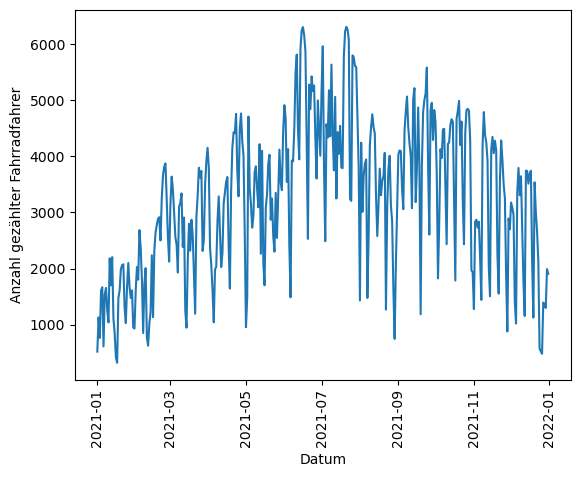

In [9]:
# plot daily counts of Freiburg at one counter site and for one channel for one year
# (TODO rausfinden, was die verschiedenen Channels sind)

# counting station
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'

# extract data
fr1_dat = counters_by_daytype_daily[(counters_by_daytype_daily.standort == city_name) & (counters_by_daytype_daily.counter_site == counter_site) & (counters_by_daytype_daily.channel_name == channel_name)]

# print shape
print('shape: ', fr1_dat.shape) # daily summed measurements for each of the 365 days in 2021

# plot daily counts for this channel
plt.plot(fr1_dat['date'], fr1_dat['zählstand'])
plt.xticks(rotation=90)
plt.xlabel('Datum')
plt.ylabel('Anzahl gezählter Fahrradfahrer');

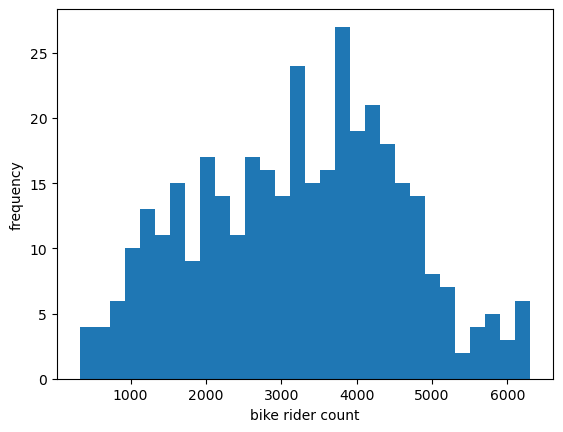

In [10]:
# plot histogram of bike rider counts
plt.hist(fr1_dat['zählstand'], bins=30) # TODO Verteilung?
plt.xlabel('bike rider count')
plt.ylabel('frequency');

In [11]:
fr1_dat

,standort,counter_site,channel_name,longitude,latitude,date,is_busday,zählstand
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,True,1668
...,...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-27,True,1395
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-28,True,1357
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-29,True,1299
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-30,True,1991


## Add temperature information to the bike rider counts

Get daily average temperature for a single day at a single location, specified by latitude and longitude.

In [12]:
def get_daily_average_temp(lat, lon, date):
    '''
    Get daily average temperature for specific location and date.
    
    Parameters
    ----------
    lat : number
        latitude
    lon : number
        longtitude
    date : Datetime
        Date for which to get average temperature
    
    Returns
    -------
    number
        Daily average temperature.
    '''
    # time period
    start = date
    end = date

    # location
    loc = Point(lat, lon)

    # import daily data
    data = Daily(loc, start, end)
    data = data.fetch()
    tavg = data['tavg'].values[0]

    return tavg

In [13]:
# add daily average temperature information
combined_daily_dat = fr1_dat
combined_daily_dat['temperature'] = combined_daily_dat.apply(lambda x : get_daily_average_temp(x['latitude'], x['longitude'], datetime(x['date'].year, x['date'].month, x['date'].day)), axis=1)
combined_daily_dat

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,standort,counter_site,channel_name,longitude,latitude,date,is_busday,zählstand,temperature
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,True,521,1.4
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,False,1131,0.8
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,False,764,-0.5
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,True,1607,0.0
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,True,1668,-0.7
...,...,...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-27,True,1395,7.0
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-28,True,1357,10.0
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-29,True,1299,9.7
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-30,True,1991,12.3


In [14]:
# adjust column names
combined_daily_dat.rename(columns = {'zählstand':'rider_count'}, inplace = True)
combined_daily_dat

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,standort,counter_site,channel_name,longitude,latitude,date,is_busday,rider_count,temperature
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,True,521,1.4
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,False,1131,0.8
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,False,764,-0.5
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,True,1607,0.0
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,True,1668,-0.7
...,...,...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-27,True,1395,7.0
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-28,True,1357,10.0
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-29,True,1299,9.7
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-30,True,1991,12.3


In [15]:
# reorder columns to have the dependent variable in the last column
combined_daily_dat = combined_daily_dat[['standort', 'counter_site', 'channel_name', 'date', 'temperature', 'is_busday', 'rider_count']]
combined_daily_dat

,standort,counter_site,channel_name,date,temperature,is_busday,rider_count
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,1.4,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,0.8,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,-0.5,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,0.0,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,-0.7,True,1668
...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,7.0,True,1395
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,10.0,True,1357
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,9.7,True,1299
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,12.3,True,1991


In [16]:
# export dataframe
combined_daily_dat.to_pickle('./../data/processed/combined_daily_dat_FR1.pkl')